# Topic Clustering Using LDA - Mallet

**Set path:**

In [7]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_LDA = os.path.join(PATH, 'results/topics/lda')
PATH_MALLET = os.path.join(PATH, 'results/topics/mallet')
sys.path.append('../src')
TRAIN_SIZE = 0.10
START = '2020_02_23'
END = '2020_07_19'
topic_subset = ['2', '4', '7', '8', '10', '11', '12', '13', '14', '17', '22', '24', '25', '27', '28']

**Load libraries:**

In [14]:
import numpy as np
import pandas as pd
from twitter_tools.utils import read_files
import pickle
import json
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import gc
import re
from operator import itemgetter
from itertools import product
from collections import Counter
from functools import partial
import seaborn as sns
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
})
tqdm.pandas()


import pyLDAvis
import pyLDAvis.gensim
from IPython.core.display import display, HTML
from nltk import FreqDist
from itertools import chain


from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.wrappers import ldamallet
from sklearn.linear_model import LogisticRegression


import ipywidgets as widgets
from ipywidgets import interact
from twitter_tools.utils import translate

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Load stopwords**

In [9]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

### Read the data:
Use a preprocessing function which removes IDs determined to be outliers by the previous analysis, tokenizes the lemmatized data and removes stopwords.

In [10]:
PATH_DROP_TWEETS = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
PATH_DROP_USERS = os.path.join(PATH, 'results/cleaning/drop_users.json')
PATH_SAMPLE = os.path.join(PATH, 'data/clean/topic_sample' + '_' + START + '_' + END + '.csv')
PATH_DICT = os.path.join(PATH, 'data/clean/topic_sample_dict' + '_' + START + '_' + END + '.p')
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean')

In [11]:
#filter function:
def filter_fun(df, drop_users, drop_tweets, cols = None):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if cols is not None:
        df = df[cols]
    return df
cols = ['full_text', 'id_str', 'day', 'retweet', 'lemmas', 'source']
drop_tweets = json.load(open(PATH_DROP_TWEETS, 'r'))
drop_users = json.load(open(PATH_DROP_USERS, 'r'))
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, cols = cols)




if os.path.isfile(PATH_SAMPLE):
    sample = pd.read_csv(PATH_SAMPLE, index_col = 0, dtype = dtypes)
    id2word = pickle.load(open(PATH_DICT, 'rb'))
    sample['lemmas'] = sample['lemmas'].astype(str).apply(ast.literal_eval)
else:
    sample = pd.DataFrame(columns = cols)
    id2word = Dictionary()
    for i, dat in enumerate(tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, 
                               filter_fun = ff, method = 'pandas'))):
        #first drop duplicates:
        dat.drop_duplicates(subset = ['lemmas'], inplace = True) #on the same day
        dat = dat.loc[np.logical_not(dat['lemmas'].isin(sample['lemmas'])),:] #from previous days
        dat.lemmas = dat.lemmas.apply(ast.literal_eval) #load lemmas as list
        id2word.add_documents(dat.lemmas.tolist()) #add documents
        dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234)) #take sample
        sample = sample.append(dat) #append to final sample
    sample.reset_index(inplace = True, drop = True)
    sample.to_csv(PATH_SAMPLE)
    pickle.dump(id2word, open(PATH_DICT, 'wb'))
corpus = [id2word.doc2bow(t) for t in sample['lemmas'].tolist()]
print(f'Data loadead. Train size {len(sample["lemmas"])}')

Data loadead. Train size 521514


## Define utility functions:

### Grid Search

In [7]:
def grid_search_lda(model, params, corpus, text, id2word, save_models = None, 
                    perplexity = True, return_best = False, verbose = False, 
                    **kwargs):

    #prepare search space:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    try:
        for i, pars in enumerate(tqdm(grid)):
            #train
            lda = model(corpus = corpus, id2word = id2word, 
                               num_topics = pars['k'], **kwargs)

            #eval
            if perplexity:
                grid[i]['perplexity'] = lda.log_perplexity(corpus)
            coherence = CoherenceModel(model=lda, texts=text, dictionary=id2word, coherence='c_v', processes=3)
            grid[i]['coherence'] = coherence.get_coherence() 

            #save
            if save_models is not None:
                lda.save(os.path.join(save_models, 'lda_' + str(pars['k'])))
                
            #print results
            if verbose:
                print(f'RESULTS: {grid[i]}')

        if return_best:
            best = sorted(grid, key = lambda x: (round(x['coherence'],2), -x['k']), reverse = True)[0] #sort by coherence
            print(f'Returning model with maximum coherence. Number of topics: {best["k"]}, Coherence score: {best["coherence"]}')
            lda = model(corpus = corpus, id2word = id2word, num_topics = best['k'], **kwargs)

            return grid, lda
        else:
            return grid
    except Exception as e:
        print(e)
        return grid, None

### LDA Prediction

In [7]:
def top_unique(lemmas:list, topics:list, n = 10, window = 50):
    topics_unique = sorted(np.unique(topics))
    topns = dict()
    for t in topics_unique:
        ind = np.where(topics == t)[0]
        texts = itemgetter(*ind)(lemmas)
        dist = FreqDist(chain.from_iterable(texts))
        topn = dist.most_common(window)
        topns[t] = topn
    cnt = Counter([w[0] for w in chain.from_iterable(topns.values())])
    unique = [w[0] for w in filter(lambda x: x[1] == 1, cnt.items())]
    uniques = {k:[(w, c) for w, c in v if w in unique] for k, v in topns.items()}
    uniques = {k:v[:n] for k, v in uniques.items()}
    return uniques

## LDA

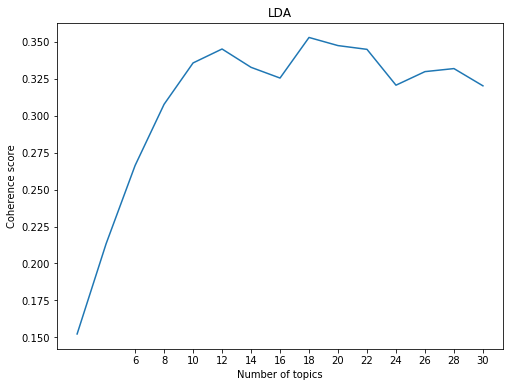

In [8]:
PATH_PARAMS = os.path.join(PATH_LDA, 'params.json')
if os.path.isfile(PATH_PARAMS):
    comparison = json.load(open(PATH_PARAMS, 'r'))
else:
    params = {'k':range(2, 32, 2)}
    comparison, lda = grid_search_lda(model = LdaMulticore, params = params, corpus = corpus, text = sample['lemmas'].tolist(), 
                                 save_models = None, id2word = id2word, return_best = True,
                                 perplexity = True, workers = 4, iterations = 200, random_state = 1234)
    lda.save(os.path.join(PATH_LDA, 'lda'))
    json.dump(comparison, open(PATH_PARAMS, 'w'))
    

#plot results    
pd.DataFrame(comparison).plot('k','coherence', title = 'LDA', legend = False, figsize = (8, 6))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.xticks(range(6, 32, 2))
plt.show()

In [12]:
#visualize topics
lda = ldamallet.LdaMallet.load(os.path.join(PATH_LDA, 'lda'))
PATH_VIS = os.path.join(PATH_LDA, 'lda.html')
if os.path.isfile(PATH_VIS):
    display(HTML(open(PATH_VIS, 'r').read()))
else:
    lda = LdaMulticore.load(os.path.join(PATH_LDA, 'lda'))
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, id2word, sort_topics = False)
    pyLDAvis.save_html(vis, PATH_VIS)
    vis

### Predict topics for the sample:

In [27]:
threshold = 0.2
ratios = []
#get list of topic probabilities sorted by probability and add 1 to each topic
topics_all = [[(w[0] + 1, w[1]) for w in sorted(lda.get_document_topics(txt, minimum_probability = 0), key = lambda x: x[1], reverse = True)] for txt in tqdm(corpus)]
topics = [topic[0][0] for topic in topics_all]
ratios = [topic[0][1]/topic[1][1] for topic in topics_all]
sample['ratio'] = ratios
sample['topic'] = topics
del ratios, topics
gc.collect()
lim = np.quantile(sample['ratio'], threshold)
sample.loc[sample['ratio'] < lim, ('topic')] = 0 #recode unknown to 0

### Plot identifying tokens:
Plot tokens that uniquely identify the topic, i.e. top n tokens within the topic that don't occur within a specific window of top tokens in the remaining topics (in here 50).

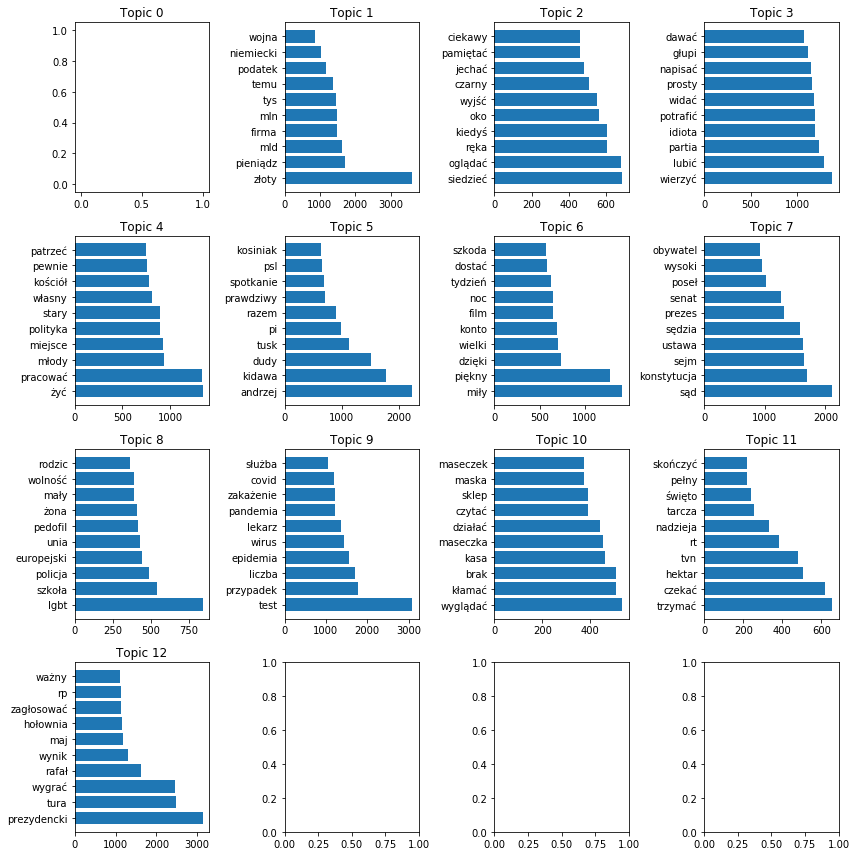

In [29]:
uniques = top_unique(sample['lemmas'].tolist(), sample['topic'].astype(int))
topics = sorted(np.unique(sample['topic'].astype(int)))
fig, ax = plt.subplots(4, 4, figsize = (12, 12))
ax = ax.ravel()
for i, (topic, words) in enumerate(uniques.items()):
    ax[i].barh([w[0] for w in words], [w[1] for w in words])
    ax[i].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

### Overall topic distribution:

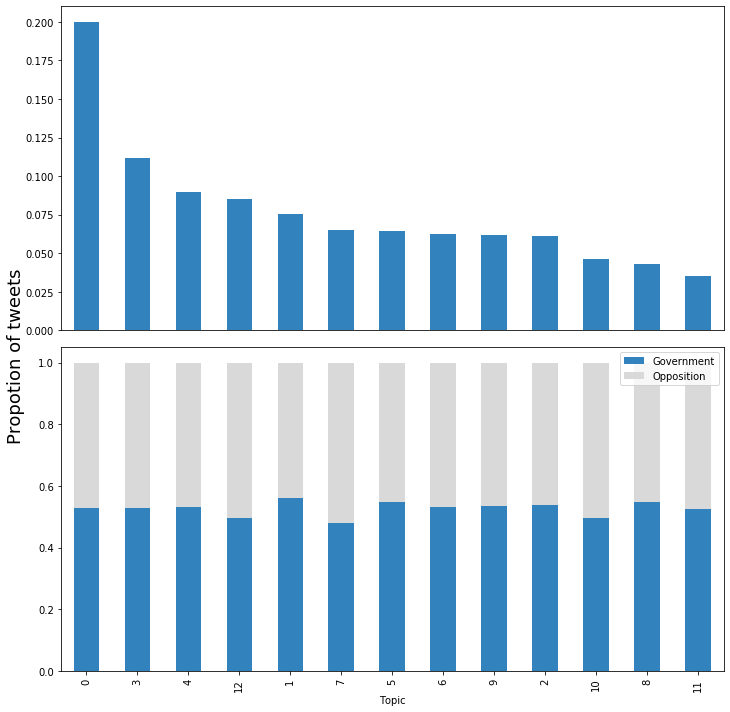

In [30]:
#prepare plot
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax = ax.ravel()

#OVERALL DISTRIBUTION
tab = pd.value_counts(sample['topic'], normalize = True)
tab.plot.bar(ax = ax[0], cmap = 'tab20c')
#get mapping for the next plot:
mapping = {k:i for i, (k, v) in enumerate(sorted(tab.items(), key = lambda x: x[1], reverse = True))}
ax[0].axes.get_xaxis().set_visible(False)

#BETWEEN-PARTY DISTRIBUTION
crosstab = pd.crosstab(sample['topic'], sample['source'], normalize = "index")
#order according to size:
key = crosstab.reset_index().topic.map(mapping)
crosstab = crosstab.iloc[key.argsort()]
crosstab.plot.bar(ax = ax[1], stacked = True, cmap = 'tab20c')
ax[1].set_xlabel("Topic")
ax[1].legend(["Government", "Opposition"])

#label
font = {'size': 18}
fig.text(-0.01, 0.5, 'Propotion of tweets', va='center', rotation='vertical', fontdict = font)
#show
plt.tight_layout()
plt.show()

### Temporal topic distribution:

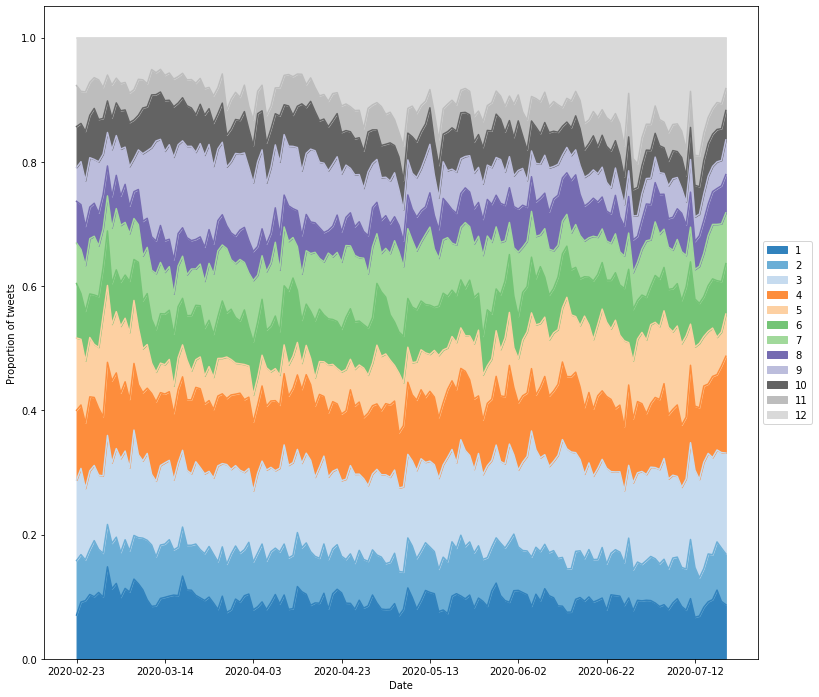

In [31]:
topic_subset = None
aggregate = sample[sample['topic'] != 0].groupby(['topic','day']).size().reset_index().rename(columns = {0:'num'}) #get counts by day and topic
daycounts = aggregate.groupby('day').agg({'num':np.sum})['num'] #get counts by day for normalization
aggregate['num'] = aggregate['num'].div(aggregate['day'].map(daycounts)) #normalize count
if topic_subset is not None:
    aggregate = aggregate[aggregate['topic'].isin(topic_subset)]
aggregate = aggregate.pivot(index = 'day', columns = 'topic', values = 'num') #reshape
#plot
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
aggregate.plot.area(ax = ax, cmap = 'tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Proportion of tweets')
ax.set_xlabel('Date')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Example tweets in each of the topics:

In [34]:
@interact
def show_best_matches(topic = list([str(t) for t in topics]), n = 10):
    inds = sorted(range(len(topics_all)), key=lambda k: topics_all[k][0][1], reverse = True)
    subind = [ind for ind in inds if topics_all[ind][0][0] == int(topic)][:n]
    for text in sample['full_text'].iloc[subind].tolist():
        print(" -" + text)

interactive(children=(Dropdown(description='topic', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',…

# LDA-Mallet

<IPython.core.display.Javascript object>


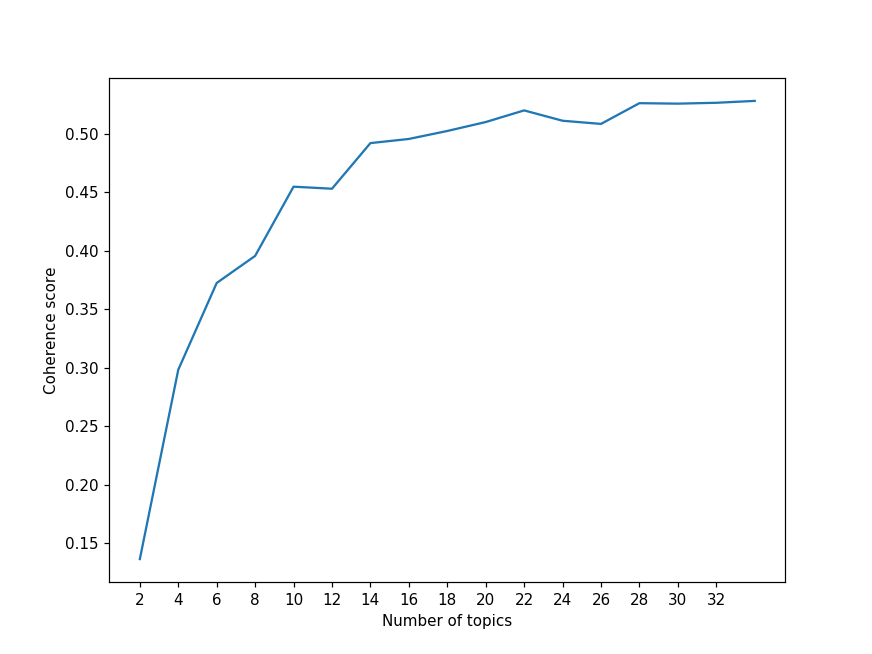

Best model with k = 28. Coherence score: 0.526


In [13]:
%matplotlib notebook
PATH_PARAMS = os.path.join(PATH_MALLET, 'params.json')
if os.path.isfile(PATH_PARAMS):
    comparison = json.load(open(PATH_PARAMS, 'r'))
else:
    params = {'k':range(2, 36, 2)}
    comparison, mallet = grid_search_lda(model = ldamallet.LdaMallet, params = params, corpus = corpus, text = sample['lemmas'].tolist(), 
                                 save_models = None, id2word = id2word, return_best = True, optimize_interval = 100, 
                                 perplexity = False, mallet_path = '/home/piotr/nlp/mallet-2.0.6/bin/mallet', 
                                         verbose = True, workers = 4, random_seed = 1234)
    mallet = ldamallet.malletmodel2ldamodel(mallet)
    mallet.save(os.path.join(PATH_MALLET, 'mallet'))
    json.dump(comparison, open(PATH_PARAMS, 'w'))
    
# visualize:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
})
best = sorted(comparison, key = lambda x: (round(x['coherence'], 2), -x['k']), reverse = True)[0]
pd.DataFrame(comparison).plot('k','coherence', legend = False, figsize = (8, 6))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.xticks(range(2, 34, 2))
plt.savefig(os.path.join(PATH, 'final/figures/coherence_grid.png'))
plt.show()
print(f'Best model with k = {best["k"]}. Coherence score: {round(best["coherence"], 3)}')

In [8]:
mallet = LdaMulticore.load(os.path.join(PATH_MALLET, 'mallet'))
#visualize topics
PATH_VIS = os.path.join(PATH_MALLET, 'mallet.html')
if os.path.isfile(PATH_VIS):
    display(HTML(open(PATH_VIS, 'r').read()))
else:
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(mallet, corpus, id2word, sort_topics=False)
    pyLDAvis.save_html(vis, PATH_VIS)
    vis

In [12]:
topic_dict = {0:"multiple", 
              1:"greetings",
              2:"rule of law", 
              3:"aggression", 
              4:"law enforcement", 
              5:"football",
              6:"reading", 
              7:"foreign affairs", 
              8:"media",
              9:"misinformation",
             10:"economy", 
             11:"politicians", 
             12:"postponing elections", 
             13:"presidential candidates", 
             14:"religion",
             15:"questions", 
             16:"food", 
             17:"family values", 
             18:"problems", 
             19:"news",
             20:"work", 
             21:"government lies", 
             22:"history/WW2", 
             23:"unk 1",
             24:"public health", 
             25:"local politics",
             26:"unk 2",
             27:"elections", 
             28:"coronavirus"}
json.dump(topic_dict, open(os.path.join(PATH_MALLET, 'topic_dict.json'), 'w'))

### Predict topics on sample:

In [10]:
threshold = 0.2
ratios = []
#get list of topic probabilities sorted by probability and add 1 to each topic
topics_all = [[(w[0] + 1, w[1]) for w in sorted(mallet.get_document_topics(txt, minimum_probability=0), key=lambda x: x[1], reverse=True)] for txt in tqdm(corpus)]
topics = [topic[0][0] for topic in topics_all]
ratios = [topic[0][1]/topic[1][1] for topic in topics_all]
sample['ratio'] = ratios
sample['topic'] = topics
del ratios, topics
gc.collect()
lim = np.quantile(sample['ratio'], threshold)
sample.loc[sample['ratio'] < lim, ('topic')] = 0 # recode unknown to 0

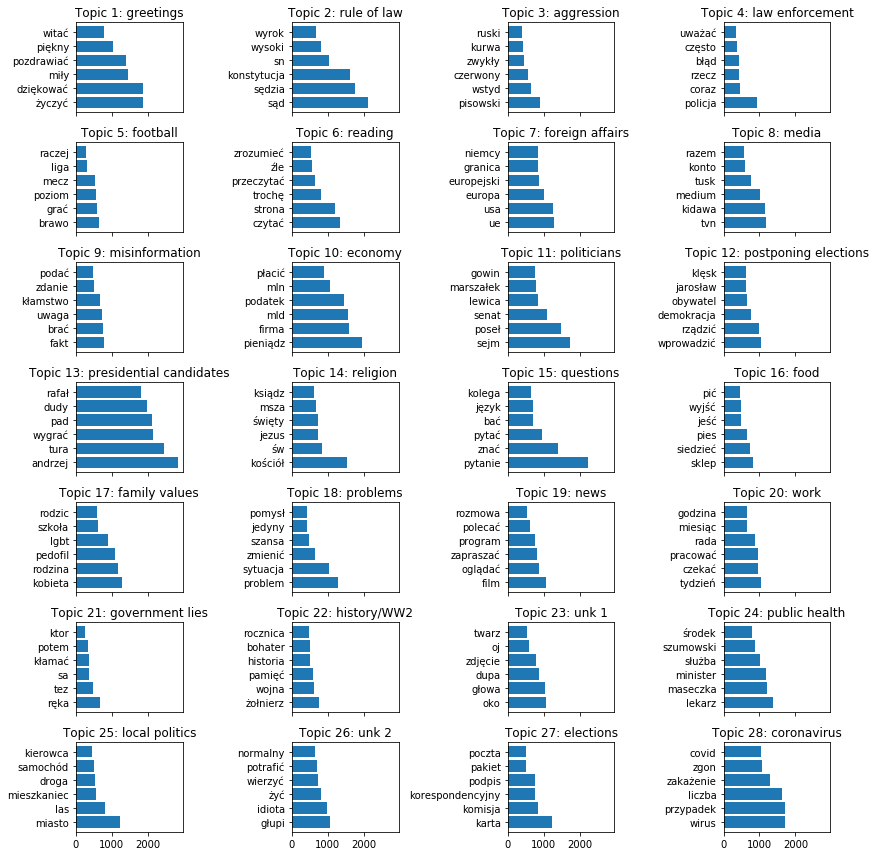

In [13]:
PATH_TOPIC_TOKENS = os.path.join(PATH_MALLET, 'topic_tokens.json')
if os.path.isfile(PATH_TOPIC_TOKENS):
    topic_tokens = json.load(open(PATH_TOPIC_TOKENS, 'r'))
else:
    topic_tokens = top_unique(sample['lemmas'].tolist(), sample['topic'].astype(int))
    topic_tokens = {int(k):[(str(a), int(b)) for a, b in v if v] for k, v in uniques.items()}
    json.dump(topic_tokens, open(PATH_TOPIC_TOKENS, 'w'))
topics = sorted([int(k) for k in topic_tokens.keys()])
side = int(np.ceil(np.sqrt(len(topics))))
fig, ax = plt.subplots(7, 4, figsize=(12, 12), sharex=True)
ax = ax.ravel()
for i, (topic, words) in enumerate(topic_tokens.items()):
    if i != 0:
        ax[i-1].barh([w[0] for w in words][:6], [w[1] for w in words][:6])
        ax[i-1].set_title(f'Topic {topic}: {topic_dict[int(topic)]}')
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'final/figures/topic_tokens_pl.png'))
plt.show()

#### Plot of the translated tokens:

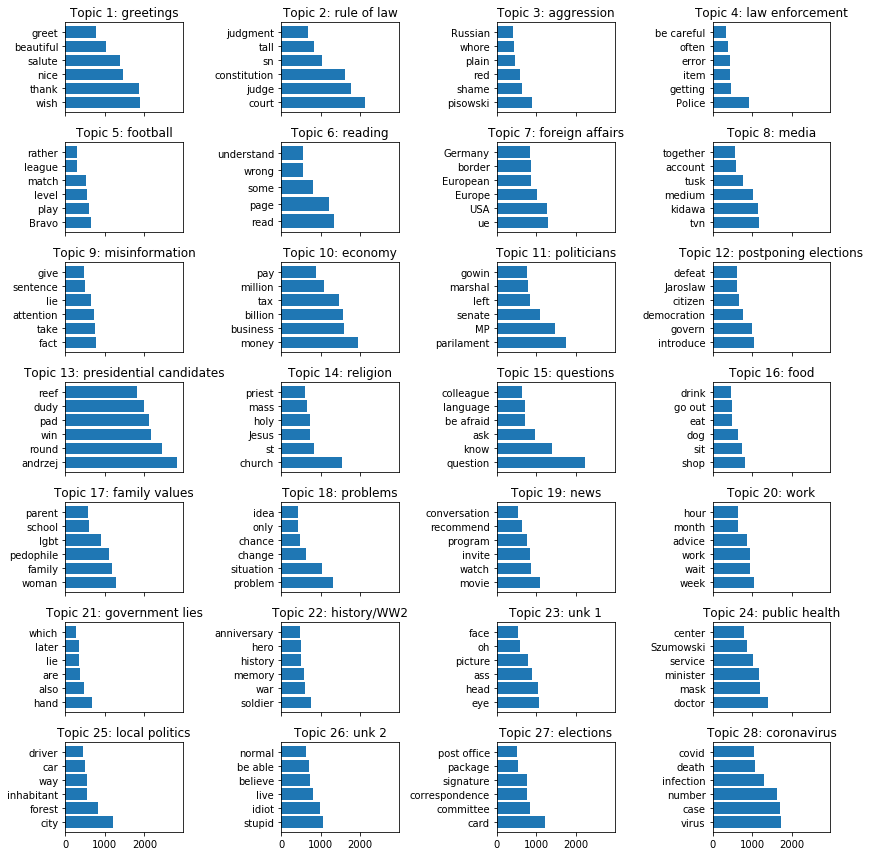

In [14]:
PATH_TOPIC_TOKENS_EN = os.path.join(PATH_MALLET, 'topic_tokens_en.json')
manual_annotation = {'poseł':'MP', 'sejm':'parilament', 'dudy':'dudy', 'rafał':'rafał'}
if os.path.isfile(PATH_TOPIC_TOKENS_EN):
    topic_tokens_en = json.load(open(PATH_TOPIC_TOKENS_EN,'r'))
else:
    topic_tokens_en = dict()
    for k, v in tqdm(topic_tokens.items()):
        if v:
            topic_tokens_en[k] = translate(v, manual=manual_annotation, retry_lim=10)
        else:
            topic_tokens_en[k] = v       
    json.dump(topic_tokens_en, open(PATH_TOPIC_TOKENS_EN, 'w'))
fig, ax = plt.subplots(7, 4, figsize=(12, 12), sharex=True)
ax = ax.ravel()
for i, (topic, words) in enumerate(topic_tokens_en.items()):
    if i != 0:
        ax[i-1].barh([w[0] for w in words][:6], [w[1] for w in words][:6])
        ax[i-1].set_title(f'Topic {topic}: {topic_dict[int(topic)]}')
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'final/figures/topic_tokens_en.png'))
plt.show()

### Overall topic distribution:

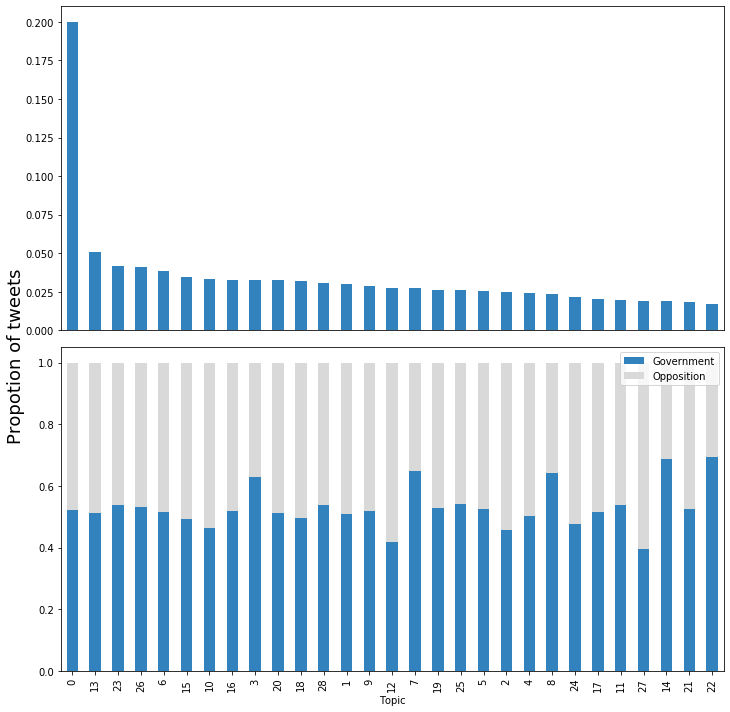

In [47]:
#prepare plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax = ax.ravel()

#OVERALL DISTRIBUTION
tab = pd.value_counts(sample['topic'], normalize = True)
tab.plot.bar(ax = ax[0], cmap='tab20c')
#get mapping for the next plot:
mapping = {k:i for i, (k, v) in enumerate(sorted(tab.items(), key=lambda x: x[1], reverse=True))}
ax[0].axes.get_xaxis().set_visible(False)

#BETWEEN-PARTY DISTRIBUTION
crosstab = pd.crosstab(sample['topic'], sample['source'], normalize="index")
#order according to size:
key = crosstab.reset_index().topic.map(mapping)
crosstab = crosstab.iloc[key.argsort()]
crosstab.plot.bar(ax = ax[1], stacked = True, cmap = 'tab20c')
ax[1].set_xlabel("Topic")
ax[1].legend(["Government", "Opposition"])

#label
font = {'size': 18}
fig.text(-0.01, 0.5, 'Propotion of tweets', va='center', rotation='vertical', fontdict=font)
#show
plt.tight_layout()
plt.show()

### Temporal topic distribution:

#### All topics:

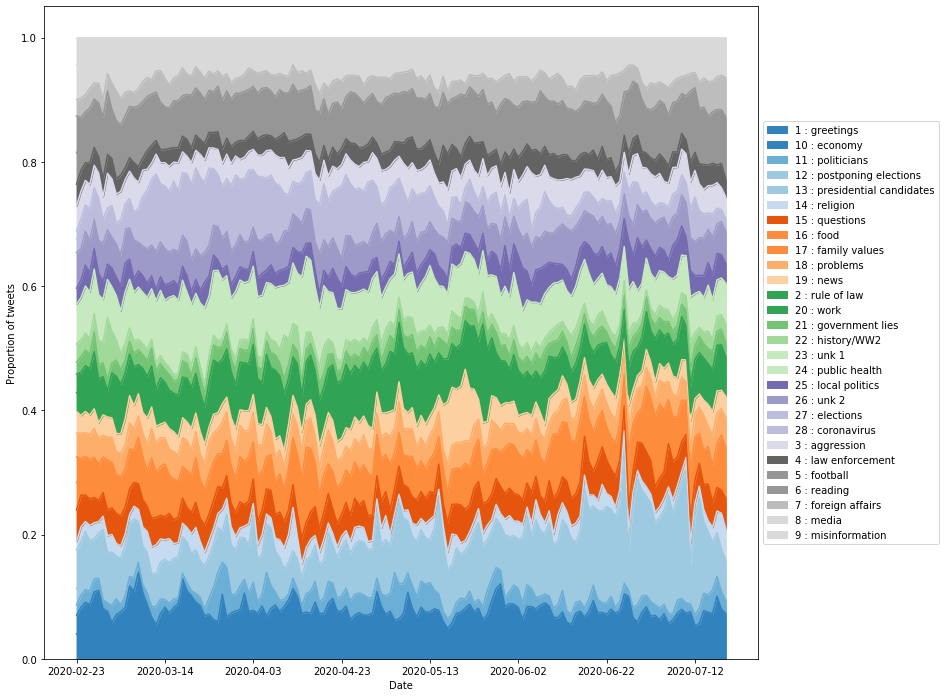

In [91]:
# get counts by day and topic
aggregate = sample[sample['topic'] != 0].groupby(['topic','day']).size().reset_index().rename(columns={0:'num'})
daycounts = aggregate.groupby('day').agg({'num':np.sum})['num'] #get counts by day for normalization
aggregate['num'] = aggregate['num'].div(aggregate['day'].map(daycounts)) #normalize count
aggregate['topic'] = aggregate['topic'].astype(str) + ' : ' + aggregate['topic'].apply(lambda x: topic_dict.get(x))
aggregate = aggregate.pivot(index = 'day', columns = 'topic', values = 'num') #reshape
#plot
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
aggregate.plot.area(ax = ax, cmap = 'tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Proportion of tweets')
ax.set_xlabel('Date')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(PATH, 'final/figures/temp_dist_all.png'),bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Selected topics:

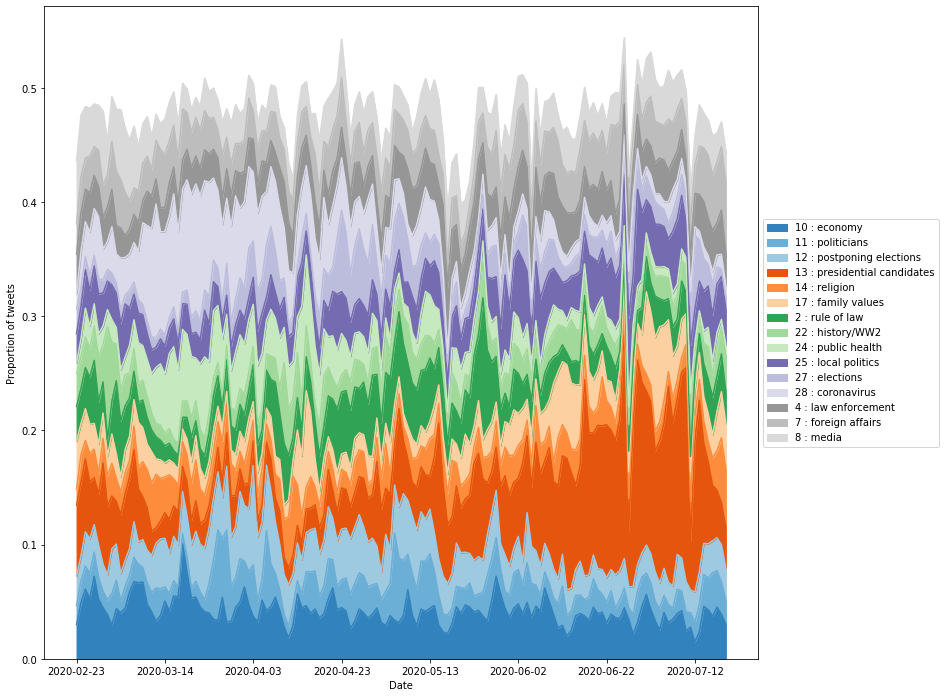

In [90]:
# get counts by day and topic
aggregate = sample[sample['topic'] != 0].groupby(['topic','day']).size().reset_index().rename(columns={0:'num'})
daycounts = aggregate.groupby('day').agg({'num':np.sum})['num'] #get counts by day for normalization
aggregate['num'] = aggregate['num'].div(aggregate['day'].map(daycounts)) #normalize count
aggregate = aggregate[aggregate['topic'].isin(topic_subset)]
aggregate['topic'] = aggregate['topic'].astype(str) + ' : ' + aggregate['topic'].apply(lambda x: topic_dict.get(x))
aggregate = aggregate.pivot(index='day', columns='topic', values='num') #reshape
#plot
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
aggregate.plot.area(ax=ax, cmap='tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Proportion of tweets')
ax.set_xlabel('Date')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(PATH, 'final/figures/temp_dist.png'), bbox_inches='tight', pad_inches=0.2)
plt.show()

### Example tweets in each of the topics:

In [49]:
@interact
def show_best_matches(topic = list([str(t) for t in topics]), n = 10):
    inds = sorted(range(len(topics_all)), key=lambda k: topics_all[k][0][1], reverse = True)
    subind = [ind for ind in inds if topics_all[ind][0][0] == int(topic)][:n]
    for text in sample['full_text'].iloc[subind].tolist():
        print(" -" + text)

interactive(children=(Dropdown(description='topic', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',…

# For the final selected model:

## Predict topics for the entire corpus
- Create a json dictionary mapping Tweet ids to cluster labels.

In [ ]:
PATH_TOPICS = os.path.join(PATH_MALLET, 'topic_map.json')
if os.path.isfile(PATH_TOPICS):
    topic_map = json.load(open(PATH_TOPICS, 'r'))
else:
    topic_map = dict()
    for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
        texts = [id2word.doc2bow(t) for t in dat.lemmas.apply(ast.literal_eval).tolist()] #get bow representation
        topics = [mallet.get_document_topics(t) for t in texts]
        topics = [sorted(t, key = lambda x: x[1], reverse = True) for t in topics]
        ratios = np.array([t[0][1]/t[1][1] for t in topics]) #compute best-second-best ratio
        topics = np.array([t[0][0] + 1 for t in topics])
        topics[ratios < lim] = 0
        topics = topics.tolist()
        topic_map.update(dict(zip(dat.id_str.tolist(), topics))) #store topics
    json.dump(topic_map, open(PATH_TOPICS, 'w'))

### Log odds of belonging to the parties given a topic:

In [88]:
PATH_ODDS = os.path.join(PATH, 'results/topics/mallet/odds.csv')
if os.path.isfile(PATH_ODDS):
    odds = pd.read_csv(PATH_ODDS, index_col = 0)
else:
    odds = dict()
    for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
        df['topic'] = df['id_str'].map(topic_map)
        day = df['day'].unique()[0]
        odds[day] = df.groupby(['topic']).apply(lambda x: LogisticRegression(fit_intercept = False).fit(np.ones(x.shape[0])[:,np.newaxis], 
                                                                                                       np.where(x['source'] == 'gov', 1, 0)).coef_[0][0])
    odds = pd.DataFrame.from_dict(odds)
    odds = odds.reset_index().melt('topic')
    odds.to_csv(PATH_ODDS)

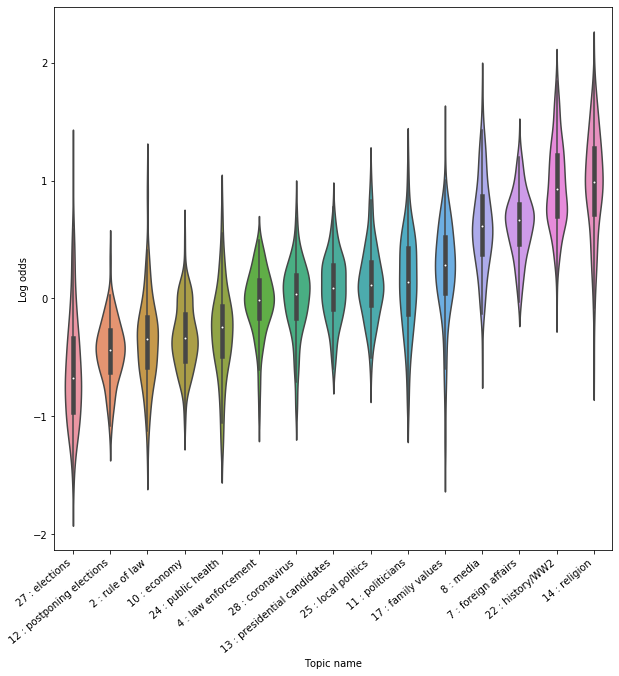

In [89]:
odds['topic'] = odds['topic'].astype(str)
if topic_subset is not None:
    odds = odds.loc[odds['topic'].isin(topic_subset), :]
odds['topic'] = odds['topic'].astype(str) + ' : ' + odds['topic'].apply(lambda x: topic_dict.get(int(x)))
order = odds.groupby('topic').agg({'value':'median'}).reset_index().sort_values('value')
order['value'] = order['value'] = np.arange(0, order.shape[0])
order = order.set_index('topic').value.to_dict()
odds['order'] = odds['topic'].apply(lambda x: order.get(x))
odds = odds.sort_values('order')
#order = odds['topic'].str.len().sort_values().index
#odds = odds.loc[order]
odds.reset_index()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x='topic', y='value', data=odds, ax=ax, cmap='tab20c')
xlabels = sorted(odds['topic'].unique(), key=lambda x: odds.loc[odds['topic'] == x, 'order'].iloc[0])
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.set_xlabel('Topic name')
ax.set_ylabel('Log odds')
plt.savefig(os.path.join(PATH, 'final/figures/topic_proba.png'), bbox_inches='tight', pad_inches=0.2)
plt.show()